# Setup
<ul>
    <li> Choose the world environment, and define a sampler function that generates random initializations of this environment.
    <li> Set up REINFORCE and define model arguments.
    <li> Train REINFORCE on an example instance of the world you set up in step one.
</ul>

### Set up the world environment

In [91]:
from sim import Continuous2D
from sim import MazeArgs

In [2]:
import numpy as np

def sample_task():
    args = MazeArgs()
    args.goal = list(np.random.uniform(low = -2, high = 2, size=(2,)))
    args.agent = [0, 0]
    maze = Continuous2D(args)
    return maze

In [92]:
# sample way to make an environment
args = MazeArgs()
args.goal = [1.3, -2]
args.agent = [0., 0.]
maze = Continuous2D(args)

### Set up REINFORCE

In [4]:
from reinforce import REINFORCE
import utils_training

from utils import ActorSmall

In [5]:
class ModelArgs():   
    def __init__(self, world):
        # type of model related arguments
        self.seed = 1
        self.state_input_size = world.state_size
        self.action_space_size = world.num_actions
        self.lr = 3e-4
        self.ppo = True
        self.ppo_base_epsilon = 0.2
        self.ppo_dec_epsilon = 0.0
        self.use_critic = True
        self.use_entropy = False

        # training related arguments
        self.gradient_clipping = True
        self.random_perm = True
        self.num_batches = 300
        self.num_mini_batches = 1
        self.batch_size = 1
        self.horizon = 100
        self.weight_func = lambda batch_num: (1 - batch_num/self.num_batches)**2
        
        # policy
        self.policy = ActorSmall
        self.log_goal_locs = False

### Train on a single world

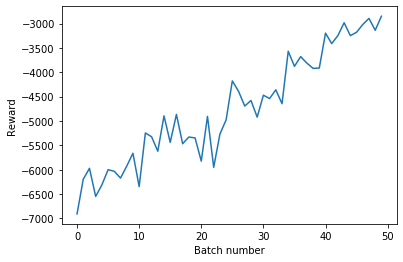

In [95]:
QUICK_RUN = False
if not QUICK_RUN:
    model_args = ModelArgs(Continuous2D)
    model_args.num_batches = 50
    model = REINFORCE(model_args)
    rewards, losses = model.train(maze.generate_fresh())

    # plot rewards
    utils_training.plot_rewards(rewards, folder=None)

# Compare different initializations from fast adaptation algorithms
<ul>
    <li> Batch REPTILE
    <li> Batch pretraining on samples of environment
    <li> Random initialization
</ul>

In [85]:
# with each method, we add the method's resulting parameters to PARAMS_LIST
PARAMS_LIST = []

### Batch REPTILE 

In [6]:
from REPTILE_training import update_init_params
from tqdm.notebook import tqdm
import copy
from collections import OrderedDict

NUM_META_ITER = 100
NUM_TASKS = 10
K = 4
ALPHA = 0.1

# random initialization
model_args = ModelArgs(Continuous2D)
model_args.num_batches = K
model_args.batch_size = 1
model = REINFORCE(model_args)

for i in tqdm(range(NUM_META_ITER)):
    tasks = [sample_task() for _ in range(NUM_TASKS)]
    
    init_params = copy.deepcopy(OrderedDict(model.policy.named_parameters()))
    temp_params = copy.deepcopy(OrderedDict(model.policy.named_parameters()))

    for t in tasks:
        model.policy.load_state_dict(init_params)
        model.init_optimizers()

        model.train(t)
        target_policy = OrderedDict(model.policy.named_parameters())

        temp_params = update_init_params(target_policy, temp_params, ALPHA/K)
    
    model.policy.load_state_dict(temp_params)

    
result = {
        "pi": model.state_dict(),
        "label": "REPTILE"
    }
PARAMS_LIST.append(result)

### Set up pretraining

In [97]:
model = REINFORCE(model_args)
model_args.num_batches = 100
model_args.batch_size = 10

# we pass the model no enviornment, but just the sampler.
rewards, losses = model.train(None, sample_task)

result = {
        "pi": model.state_dict(),
        "label": "PRETRAIN"
    }
PARAMS_LIST.append(result)

### Random model initialization

In [86]:
model = REINFORCE(model_args)

result = {
        "pi": model.state_dict(),
        "label": "RANDOM"
    }
PARAMS_LIST.append(result)

### Compare the adaptation speed of initial parameters

In [88]:
import scipy.stats
import matplotlib.pyplot as plt
import utils_training

In [83]:
NUM_ADAPTATION_STEPS = 10

model_args.num_batches = 1
model_args.batch_size = 1
model_args.num_mini_batches = 1
utils_training.compare_parameter_initializations(params_list, model_args, NUM_ADAPTATION_STEPS)

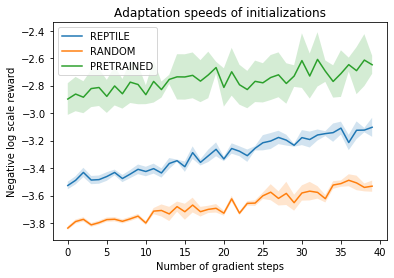

In [96]:
utils_training.plot_adaptation(params_list)